In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

# 사이킷런 데이터셋은 비슷한 딕셔너리 구조를 가짐
## 데이터셋 설명하는 DESCR키
## 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
## 레이블 배열을 담은 target 키

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [ ]:
X, y = mnist['data'], mnist['target']

print(X.shape, y.shape)
# 이미지가 70000개, 각 이미지에는 784개 특성 보유
# 이미지가 28 x 28 픽셀이기 때문

(70000, 784) (70000,)


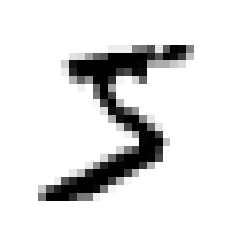

In [ ]:
import matplotlib as map
import matplotlib.pyplot as plt 

some_digit = X[0] 
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()

In [ ]:
y[0] # 5로보이는데,실제 레이블도 5인지 확인

'5'

In [ ]:
y = y.astype(np.uint8) # 문자열이 아니라 정수로 변환

In [ ]:
# 항상 데이터 셋 분류한 후 탐색하기 
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
# 이진분류기 훈련 binary classifier

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [ ]:
# SGDRegressor 확률적 경사하강법으로 진행 : 빠른 이유? SGD가 한번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문
# SGD가 샘플을 섞어야 하는 경우도 있는데, 기본적으로 epoch마다 훈련데이터를 다시 섞는다

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 1006)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=1006, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

In [ ]:
# 성능측정
## 분류기 평가는 회귀 모델보다 훨씬 어려움
## 사용할 수 있는 성능 지표가 아주 많음



In [ ]:
# 교차 검증을 사용한 정확도 측정
## 사이킷런 기능의 cross_val_score()와 거의 동일한 작업을 수행하는 함수

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone 

skfolds = StratifiedKFold(n_splits = 3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf) # sgd_clf 를 복사 
    X_train_folds = X_train[train_index] # 여기로 학습셋의 인덱스 받음
    y_train_folds = y_train_5[train_index] # 여기로 학습셋 인덱스 받음
    X_test_fold = X_train[test_index] # 여기로 테스트셋 인덱스 받음
    y_test_fold = y_train_5[test_index] # 여기로 텍스트셋 인덱스 받음

    clone_clf.fit(X_train_folds, y_train_folds) # 복제한 모델에 학습셋 넣음
    y_pred = clone_clf.predict(X_test_fold) # 학습된 모델 내 테스트셋 넣음 
    n_correct = sum(y_pred == y_test_fold) # y_test_fold 와 같은 경우 (TRUE) 를 더함
    print(n_correct / len(y_pred)) #전체 대비 맞춘 확률을 구해줌

0.96475
0.96775
0.9615


In [ ]:
# cross_val_score() 함수로로 위와 같이 진행할 수 있음
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

# 모든 값의 정확도가 95%, 맞는 것일까? 아니다
# 원래 데이터의 5인 확률 자체가 너무나 적기 떄문에, 아니라고 단순 예측해도 되어 결과가 왜곡됌


array([0.9654 , 0.95345, 0.9456 ])

In [ ]:
from sklearn.base import BaseEstimator 

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        return self 
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

# 0으로 예측해도 90% 이상의 정확도를 보임
# 이는 불균형 데이터셋을 다룰 때 종종 발생하는 경우
## 이러한 오류를 해결하기 위해서는 오차 행렬로 비교해야 할 필요가 있음
## 클래스 A 샘플이 클래스 B로 분류된 횟수를 세는 것

array([0.91125, 0.90855, 0.90915])

In [ ]:
# 오차행렬
# 오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 예측값을 만들어야 함
# 테스트로 예측을 만들 수 있으나 여기서 사용하면 안된다.
## 테스트셋은 분류기가 출시 준비를 마치고 나서 프로젝트의 맨 마지막에 사용됨

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

# cross_val_predict() 는 cross_val_score() 함수와 같이 k-fold 교차 검증 수행하나, 
# 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환

In [ ]:
# confusion_matrix() 함수를 사용해 오차 행렬을 만들 준비가 되었다
from sklearn.metrics import confusion_matrix 
confusion_matrix(y_train_5, y_train_pred)

# 여기서의 행은 실제 클래스, 열은 예측 클래스

array([[52700,  1879],
       [  832,  4589]])

In [ ]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [ ]:
# 정밀도 : 양성 예측의 정확도
## tp = (tp + fp) : 진짜 양성의 수 + 거짓 양성의 수 중에서, 진짜 양성을 예측하는 것
# 재현율 : 분류기가 정확하게 감지한 양성 샘플의 비율
## tp = (tp + fn) : 진짜 양성의 수 + 거짓 음성의 수 중에서 진짜 양성을 예측하는 것
### tpr 이라고도 함



In [ ]:
# 3.3.3 정밀도와 재현율 
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)  # 5로 판별된 이미지 중에서 90% 만 정확

0.7094928880643167

In [ ]:
recall_score(y_train_5, y_train_pred) # 전체 숫자 5중에서 84% 감지

0.8465227817745803

In [ ]:
# 그렇다면, 5로 판별된 이미지 중에 감지 잘하는 것과, 전체 5중에서 감지 잘하는 정도를 같이 보고 싶다면 어떻게 할까? 
# f점수, 라는 하나의 숫자롬 ㅏㄴ들면 된다
# f 점수는 정밀도와 재현율의 조화평균
## f = 2 * ( (1 / 정밀도) + (1 / 재현율))

from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

# 정밀도와 재현율이 비슷한 분류기에서는 f1 의 점수가 높다
# 그러나 항상 바람직한 것이 아니고, 상황에 따라 정밀도가 중요하거나, 재현율이 더 중요할 수 있다
# 만약 아이에게 안전한 동영상을 골라낼 때, 낮은 재현율을 가지고 있더라도 안전한 것을 노출시키는 높은 정밀도 분류기가 좋을 것
# 정확해야 하는 범죄자 걸러내는 모델의 경우, 재현율 > 정밀도 
# 안전해야 하는 나쁜 동영상 가이드 모델의 경우, 재현율 < 정밀도 
#--> 정밀도 / 재현율 트레이드 오프


0.7719740937000589

In [ ]:
# 정밀도 / 재현율 트레이드오프는 어떻게 구성되는가? 
## 결정함수를 사용하여 각 샘플의 점수 계산 시 가능
# 임계값보다 크면 샘플을 양ㅇ성 클래스에 할당, 작으면 음성 클래스에 할당

# 결정 임계값이 높을 경우, (더 깐깐해지는 것이므로) 양성 예측하는 경우가 줄어들면서 재현율은 줄어들고, 정밀도는 높아진다
# 결정 임계값이 낮을 경우, (더 많이 봐주는 것이므로) 음성 예측하는 경우가 줄어들면서 정밀도가 줄어들고, 재현율은 높아진다

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

threshold = 0
y_some_digit_pred

NameError: ignored

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)

y_some_digit_pred

In [ ]:
y_scores

In [ ]:
# 임곗값 높이면 재현율이 줄어든다
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, 
                            method = 'decision_function')

In [ ]:
# 이 점수로 precision_recall_curve() 함수를 사용하여 모든 임곗값에 대한
# 정밀도와 재현율 계산이 가능

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores) 


In [ ]:
def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label = '정밀도')
    plt.plot(thresholds, recalls[:-1], 'g-', label = '재현율')

plot_precision_recall_vs_thresholds(precisions, recalls, thresholds)
plt.show()

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

# 누군가가 99%의 accuracy 를 달성하자, 라고 말하면 반드시 
# 재현율 얼마에서? 라고 물어봐야 한다고 한다. 

In [ ]:
# 3.3.5 ROC 곡선
from sklearn.metrics import roc_curve 

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [ ]:
def plt_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0, 1], 'k--')
plt_roc_curve(fpr, tpr)
plt.show()

In [ ]:
# 곡선 아래의 면적 auc 를 측정하면 분류기를 비교할 수 있음
# 완벽한 분류기는 roc의 auc가 1이고, 완전한 랜덤 분류기는 0.5 dlek

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

In [ ]:
# RandomForestClassifiere 를 훈련시켜서 SGDClassifier 의 ROC곡선과 
# ROC AUC 점수를 비교
 
from sklearn.ensemble import RandomForestClassifier 

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5,
                                    cv = 3, method = 'predict_proba')

# predict_proba() 메서드는 샘플이 행, 클래스가 열이고 
# 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환
# 예를 들어 어떤 이미지가 5일 확률 70%

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

In [ ]:
y_probas_forest # [음성 클래스에 속할 확률, 양성 클래스에 속할 확률]

In [ ]:
plt.plot(fpr, tpr, 'b:', label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, '랜덤포레스트')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# 3.4 다중분류
## 다중 분류기는 둘 이상의 클래스를 구별할 수 있음
## 로지스틱,SVM은 이진 분류만 가능하여, 이진 분류기를 여러개 사용해 다중 클래스 분류 가능
## SGD, random forest, naiva bayes 는 여러 클래스를 직접 처리 가능
### one-versus-the-rest 전략 : 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개를 훈련 하여 이미지 분류 시스템 만들기
### one-versus-one 전략 : 0과 1구별, 0과 2구별, 1과 2구별 등 각 숫자의 조합마다 이진 분류기 훈련

# 일부 알고리즘은 훈련 세트 크기에 민감
# 큰 훈련 세트에서 몇 개의 분류기를 훈련시키는 것 < 작은 훈련 세트에서 많은 분류기를 훈련
# 다중 클래스 분류 작업에 이진 분류 알고리즘을 선택시
# 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO를 실행


In [ ]:
from sklearn.svm import SVC
svm_clf = SVC()
# 이렇게 될 경우, 내부에서는 사이킷런이 ovo전략을 사용해 45개 이진 분류기 훈련
# 각각의 결정점수를 얻어 점수가 가장 높은 클래스를 선택
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores # 그럼 여기서는 ovo를 하니까 10개의 점수가 나오고
# 그 중에서 가장 높은 값을 내는 구나
# 그럼 svm_clsification 도 일종의 앙상블인가? 아닐 듯
## 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택한다? 
## 결정 점수? 각 값이 될 점수? 
## 그럼 오히려 높은 점수일 수록 결정 점수를 

In [ ]:
np.argmax(some_digit_scores)
svm_clf.classes_

In [ ]:
from sklearn.multiclass import OneVsRestClassifier 
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

len(ovr_clf.estimators_)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

In [ ]:
sgd_clf.decision_function([some_digit])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring = 'accuracy')

In [ ]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

In [ ]:
#3.5 에러분석
## 데이터 준비 단계에서 가능한 선택 사항을 탐색
## 여러 모델을 시도
## 가장 좋은 몇 개를 골라 GridSearchCV를 사용해 하이퍼 파라미터 튜닝
# -> 자동화

# 오차 행렬 살펴보기 : cross_val_predict() 함수를 사용해 예측 생성, 
## confusion_matrix() 함수를 호출

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv =3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
# 오차행렬을 이미지로 봐보자
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

# 에러 부분에 초점을 맞춰보자
# 오차 행렬의 각 값에
# 대응되는 클래스 이미지 갯수로 나누어 에러율 비교



In [ ]:
row_sums = conf_mx.sum(axis =1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

# 이 그림에서 행은 실제 클래스를 나타내고
# 열은 예측한 클래스를 나타낸다는 사실을 기억
# 클래스 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었음을 암시


In [ ]:
cl_a = cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

plt.show()

In [ ]:
# 대부분의 잘못 분류된 이미지는 확실히 에러인 것 같고, 분류기가 실수한 이유를 이해하기 어렵다
# 원인은 선형 모델인 SGDClassifier 를 사용했기 때문
# 선형 분류기는 클래스마다 픽셀에 가중치를 할당
# 새로운 이미지에 대해 단순히 픽셀 강도의 가중치합을 클래스의 점수로 계산
# 3과 5는 몇개의 픽셀만 다르기 때문에 모델이 쉽게 혼동하게 됨

# 3과 5의 주요 차이는 위쪽 선과 아래쪽 호를 이어주는 작은 직선의 위치 
# 숫자 3을 쓸 때는 연결부위가 조금 왼쪽으로 치우치면 분류기가 5로 분류
# 반대도 마찬가지

# 3과 5의 에러를 줄이는 한가지 방법은 이미지를 중앙에 위치시키고 
# 회전되지 않도록 전처리 하는 것


In [ ]:
# 3.6 다중 레이블 분류
# 분류기가 샘플마다 여러개 클래스를 출력해야 할때는 어떨까?
# 같은 사진에 여러 사람이 등장한다면 어떻게 해야할까?
# 인식된 사람마다 하나씩 꼬리표를 붙여야 한다
# 분류기가 앨리스, 밥, 찰리 얼굴 셋이라면 [1, 0, 1] 이라고 출력해야 함
# 다중 레이블 분류

In [ ]:
from sklearn.negihbors import KNeighborsClassifier

y_train_large = (y_train>=7) # 이 숫자가 7보다 큰 값인가? 7, 8, 9
y_train_odd = (y_train %2 == 1) # 이 숫자가 홀수인가? 
y_multilabel=np.c_[train_larget, ytrain_odd]

knn_clf = KNeighborsClassifier() # 인스턴스를 만들고
knn_clf.fit(X_train, y_multilabel) # 다중 타깃 배열을 사용하여 훈련

In [ ]:
knn_clf.predict([some_digit]) # False, True 라고 나온다면, 이 숫자는 7보다 작고, 홀수

In [ ]:
# 다중 레이블 분류기 평가 방법은 많다
# 적절 지표는 프로젝트에 따라 다름
# 각 레이블의 F1 점수를 구하고, 간단히 평균 점수를 계산

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

# 0.97541... 이 나오는데
# 이 코드는 모든 레이블의 가중치가 같다고 가정한 것
# 앨리스 사진이 밥이나 찰리 사진보다 훨씬 많다면 앨리스 사진에 대한 분류기의 점수에
# 더 높은 가중치를 둘 것
# 레이블에 클래스의 지지도 support 를 가중치를 주는 것 -> average 부분
# average = 'weighted' 로 설정하면 됨

In [ ]:
# 다중 출력 분류
## 한 레이블이 다중 클래스가 될 수 있도록 일반화 한 것

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mode = X_train
y_test_mode = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

In [ ]:
# 뷴류 작업에서 좋은 측정 지표를 선택하고
# 적절한 정밀도/재현율 트레이드오프를 고르고
# 분류기를 비교하는 방법
## 여러 종류의 문제에서 훌륭한 분류 시스템을 구축하는 방법을 알게 되었길


# 3.8 연습문제
## 1. mnist dataset 으로 분류기 만들기

- 과제 확인하고 데이터 생김새, 분류/ 회귀, 목적에 따른 메트릭 선택
- 학습, 데이터셋 생성
- 필요한 모델 여러개 : 여기서는 kneightborsclassifier 를 이야기 해줌
- 데이터 분석, 에러분석, 
- 하이퍼파라미터 튜닝

In [ ]:
# 과제 확인하고 데이터 생김새, 분류회귀, 목적에 따른 메트릭 선택
# 이 문제는 이미지 -> 픽셀로 변형한 문제이며
# 여러 변형을 통해 최종값이 0~9까지로 분류하는 문제, 다중분류문제
# 아마 f1 score 를 사용할 것이다. 재현율이 특정 수준이 되는 조건에서 최고의 정확성을 올려

# 필요 데이터 받아오기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [ ]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [ ]:
y.shape

(70000,)

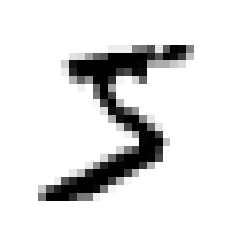

In [ ]:
# 데이터를 확인한다고 했으니까 아래 코드로 확인해본다
import matplotlib as mlp
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()

In [ ]:
# 학습셋 테스트셋 구분하기
# 모델 단순히 불러들여서 모델에 학습시킨 후
# 최종 테스트 값의 정확도가 얼마 나오는지 확인

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)



0.972

In [ ]:
ac_score = accuracy_score(y_test, y_pred)
ac_score # 처음부터 목표하던 97%의 정확도를 달성했다 세상에

# 여기서 문제 확인하기, 어디서 문제였을까? 
# 데이터 자체의 문제는 아니었을 것이다
# 우리가 앤드ㄹ

0.972

In [ ]:
f1_score(y_test, y_pred, average = 'weighted')

0.9719376457588427

In [ ]:
knn.get_params

<bound method BaseEstimator.get_params of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')>

In [ ]:
# 하이퍼파라미터 튜닝
# 그리드 탐색을 시작

from sklearn.model_selection import GridSearchCV
param_grid = [
              {'weights' : ['distance', 'uniform'],
               'n_neighbors' : [3, 5, 10, 20]}
]

grid_search = GridSearchCV(knn, param_grid, cv = 3,
                           scoring = 'accuracy',
                           return_train_score = True)
grid_search.fit(X_train, y_train)


## 2번 문제 :
- mnist 이미지를 (왼, 오른, 위, 아래) 어느 방향으로든 한 픽셀 이동시킬수 있는 함수를 만들기
- 그런 다음 훈련 세트에 있는 각 이미지에 대해 네개의 이동된 복사봉(방향마다 한 개씩)을 만들어 훈련세트에 추가
- 이 확장된 데이터셋에서 앞에서 찾은 최선의 모델을 훈련
- 테스트셋에서 정확도를 측정
- 모델의 성능이 더 높아졌는가?
+ 인위적으로 훈련셋을 늘리는 이 기법 : 데이터 증식 data augmentation

In [ ]:
from scipy.ndimage.interpolation import *
# shift() 함수를 사용하면 
# shift(image, [2, 1], cval = 0) 은 아래로 2픽셀, 오른쪽으로 1픽셀 이동

In [ ]:
for i 